# Dataviz coronavirus

In [130]:
import pandas as pd
import numpy as np
from datetime import timedelta
from datetime import datetime
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
%matplotlib inline

## Recupero degli ultimi dati

I dati provengono dalla repository ufficiale della Protezione Civile italiana. https://github.com/pcm-dpc/COVID-19

In [131]:
data = pd.read_json("https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-json/dpc-covid19-ita-andamento-nazionale.json")

In [132]:
data = data.loc[:,['data','totale_casi']]
FMT = '%Y-%m-%dT%H:%M:%S'
data['data'] = data['data'].map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("2020-01-01T00:00:00", FMT)).days  )
print("Dati negli ultimi sette giorni📅")
data[-7:]

Dati negli ultimi sette giorni📅


,data,totale_casi
24,78,41035
25,79,47021
26,80,53578
27,81,59138
28,82,63927
29,83,69176
30,84,74386


# Grafico tasso di crescita

In [133]:
data['differenza_giorno_precedente'] = data.diff()['totale_casi']
data['tasso_crescita'] = round(data['differenza_giorno_precedente'] / (data['totale_casi'] - data['differenza_giorno_precedente']) * 100, 1)
data["tasso_crescita"].fillna(0)
data[-7:]

,data,totale_casi,differenza_giorno_precedente,tasso_crescita
24,78,41035,5322.0,14.9
25,79,47021,5986.0,14.6
26,80,53578,6557.0,13.9
27,81,59138,5560.0,10.4
28,82,63927,4789.0,8.1
29,83,69176,5249.0,8.2
30,84,74386,5210.0,7.5


ValueError: cannot convert float NaN to integer

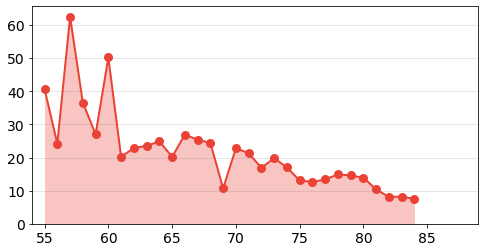

In [134]:
def infection_grow(x, y):
    plt.rc('font', size=14)
    plt.figure(figsize=(8, 4))
    plt_axes = plt.gca()
    plt_axes.grid(axis='y', color=(0.4, 0.4, 0.4), alpha=0.2)
    plt.stackplot(x, y, color=(0.92, 0.26, 0.21, 0.3), linewidth=0)
    plt.plot(x, y, color=(0.92, 0.26, 0.21), linewidth=2)
    plt.scatter(x, y, color=(0.92, 0.26, 0.21), label="Italy", linewidth=3)
    plt.xlim(int(min(x)), int(max(x) + 5))
    plt.ylim(0, int(max(y)))
    plt.title("Percentuale di crescita giornaliera")
    plt.xlabel("Giorni dall'1-1-2020")
    plt.ylabel("Daily % increase")
    plt.legend()
    plt.show()
infection_grow(data['data'].tolist(), data['tasso_crescita'].tolist())

In [135]:
def logistic_model(x,a,b,c):
    return c / (1 + np.exp(-(x - b) / a))

x = list(data.iloc[:,0])
y = list(data.iloc[:,1])
fit = curve_fit(
    logistic_model, 
    x, 
    y,
    p0=[2,100,20000]
)
a = fit[0][0]
b = fit[0][1]
c = fit[0][2]

In [136]:
asymptote = int(fsolve(lambda x : logistic_model(x, a, b, c) - int(c),b))
asymptote

140

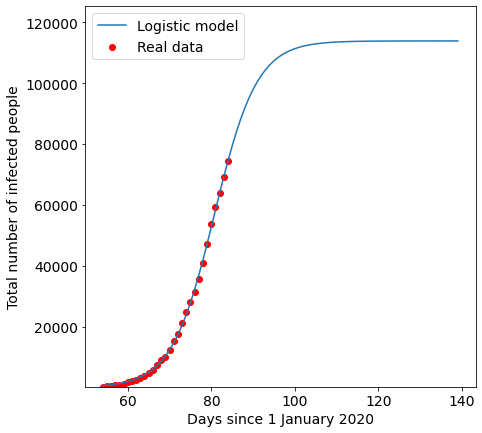

In [137]:
pred_x = list(range(max(x),asymptote))
plt.rcParams['figure.figsize'] = [7, 7]
plt.rc('font', size=14)
# Real data
plt.scatter(x,y,label="Real data",color="red")
# Predicted logistic curve
plt.plot(x +pred_x, [logistic_model(i,fit[0][0],fit[0][1],fit[0][2]) for i in x + pred_x], label="Logistic model" )

plt.legend()
plt.xlabel("Days since 1 January 2020")
plt.ylabel("Total number of infected people")
plt.ylim((min(y)*0.9,c*1.1))
plt.show()

## Aggiorniamo il dataset con i nuovi dati

ValueError: cannot convert float NaN to integer

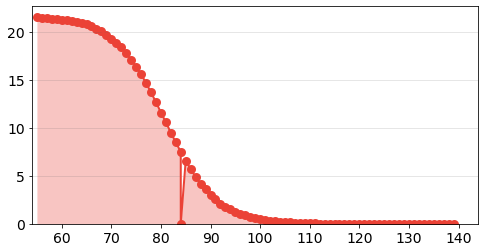

In [138]:
d = {'data': x +pred_x, 'totale_casi': [logistic_model(i,fit[0][0],fit[0][1],fit[0][2]) for i in x + pred_x]}
df = pd.DataFrame(data=d)
df['differenza_giorno_precedente'] = df.diff()['totale_casi']
df['tasso_crescita'] = round(df['differenza_giorno_precedente'] / (df['totale_casi'] - df['differenza_giorno_precedente']) * 100, 1)
infection_grow(df['data'].tolist(), df['tasso_crescita'].tolist())

# Quando finirà l'epidemia?

In [141]:
date_1 = datetime.strptime("2020-1-1", "%Y-%m-%d")
end_date = date_1 + timedelta(days=asymptote)
print(end_date)

2020-05-20 00:00:00
